# Group 14 - Project FP01
## Time series anomaly detection - XGBoost with Sliding Window

This project aims at investigating the current state-of-the-arts TAD scenario using XGBoost with a sliding window approach.

In [5]:
# !pip install pandas==1.5.3
# !pip install tsfel
# !pip install xgboost
# !pip install -U kaleido

In [2]:
import os
import time
import tsfel
import warnings
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from dataset import get_df_action, get_features_ts, get_train_test_data
from plots import plot_anomalies, plot_anomalies_over_time, plot_roc_curve
from metrics import compute_metrics

# Set style for matplotlib
plt.style.use("Solarize_Light2")

2024-07-21 21:50:42.969657: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-21 21:50:43.265808: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-21 21:50:43.265853: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-21 21:50:43.267153: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-21 21:50:43.341854: I tensorflow/core/platform/cpu_feature_g

In [3]:
# Path to the root directory of the dataset
ROOTDIR_DATASET_NORMAL = '../../dataset/normal'
ROOTDIR_DATASET_ANOMALY = '../../dataset/collisions'

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

### Data Loading and Preprocessing

In [4]:
freq = '0.1'

# NORMAL DATA
filepath_csv = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_{freq}s.csv") for r in [0, 2, 3, 4]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_{freq}s.metadata") for r in [0, 2, 3, 4]]
df_action, df, df_meta, action2int = get_df_action(filepath_csv, filepath_meta)

# COLLISION DATA
filepath_csv = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_{freq}s.csv") for r in [1, 5]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_{freq}s.metadata") for r in [1, 5]]
df_action_collision, df_collision, df_meta_collision, action2int_collision = get_df_action(filepath_csv, filepath_meta)

filepath_csv = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec1_collision_20220811_rbtc_{freq}s.csv")]
filepath_meta = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec1_collision_20220811_rbtc_{freq}s.metadata")]
df_action_collision_1, df_collision_1, df_meta_collision_1, action2int_collision_1 = get_df_action(filepath_csv, filepath_meta)

filepath_csv = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec5_collision_20220811_rbtc_{freq}s.csv")]
filepath_meta = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec5_collision_20220811_rbtc_{freq}s.metadata")]
df_action_collision_5, df_collision_5, df_meta_collision_5, action2int_collision_5 = get_df_action(filepath_csv, filepath_meta)

Loading data.
Found 31 different actions.
Loading data done.

Loading data.
Found 31 different actions.
Loading data done.



### Features Extraction

In [7]:
start_time = time.time()
frequency = 1/float(freq)
df_features = get_features_ts("statistical", df_action, df_meta, frequency, action2int)
df_features_collision = get_features_ts("statistical", df_action_collision, df_meta_collision, frequency, action2int_collision)
df_features_collision_1 = get_features_ts("statistical", df_action_collision_1, df_meta_collision_1, frequency, action2int_collision_1)
df_features_collision_5 = get_features_ts("statistical", df_action_collision_5, df_meta_collision_5, frequency, action2int_collision_5)
print("--- %s seconds ---" % (time.time() - start_time))

Computing features.


Skipped feature extraction for pickFromPallet(1,2)=[true,1,0] 2022-08-11 14:37:37.436000 : 2022-08-11 14:37:37.421000.
Skipped feature extraction for placeToPallet(1,1)=[true,0] 2022-08-11 14:37:37.421000 : 2022-08-11 14:37:37.442000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.568000 : 2022-08-11 15:36:32.533000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.572000 : 2022-08-11 15:36:32.561000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.533000 : 2022-08-11 15:36:32.572000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.561000 : 2022-08-11 15:36:32.561000.
Computing features done.
Computing features.


Skipped feature extraction for moveOverPallet(1,3)=[true,0] 2022-08-11 16:55:15.149000 : 2022-08-11 16:55:15.146000.
Skipped feature extraction for moveOverPallet(3,1)=[true,0] 2022-08-11 16:55:15.146000 : 2022-08-11 16:55:15.150000.
Computing features done.
--- 156.73086309432983 seconds ---


In [8]:
X_train, y_train, X_test, y_test = get_train_test_data(df_features, df_features_collision, full_normal=True)
X_train1, y_train1, X_test1, y_test1 = get_train_test_data(df_features, df_features_collision_1, full_normal=True)
X_train5, y_train5, X_test5, y_test5 = get_train_test_data(df_features, df_features_collision_5, full_normal=True)

X_train shape: (973, 2200)
y_train shape: (973,)
X_test shape: (306, 2200)
y_test shape: (306,)
X_train shape: (973, 96)
y_train categorical shape: (973, 31)
y_train shape: (973,)
X_test shape: (306, 96)
y_test shape: (306,)
Training data shape: (973, 96)
Testing data shape: (306, 96)


## XGBoost for Anomaly Detection with Sliding Window

In [22]:
def sliding_window_anomaly_detection(X_train, y_train, window_size=300, stride=30):
    anomaly_scores = []
    scaler = StandardScaler()
    model = XGBRegressor(n_estimators=100, learning_rate=1, random_state=42)
    
    for i in range(0, len(X_train), stride):
        # Select window of training data
        start_idx = max(0, i-window_size)
        end_idx = min(len(X_train), i)
        train_window = X_train.iloc[start_idx:end_idx]
        train_labels = y_train.iloc[start_idx:end_idx]
        
        # Ensure we have data to process
        if len(train_window) == 0:
            print(f"Warning: Empty training window at index {i}. Skipping.")
            #train_window = X_train
            #train_labels = y_train
            pass
        else:
            # Normalize data
            train_scaled = scaler.fit_transform(train_window)
            
            # Ensure we have test data to process
            #test_slice = X_test.iloc[i:min(i+stride, len(X_test))]
            #if len(test_slice) == 0:
            #    break  # No more test data to process
            
            #test_scaled = scaler.transform(test_slice)
            
            # Train model
            model.fit(train_scaled, train_labels)
            
            # Compute anomaly scores (using prediction error)
            #test_pred = model.predict(test_scaled)
            #mse = np.mean(np.power(test_scaled - test_pred.reshape(-1, 1), 2), axis=1)
            #anomaly_scores.extend(mse)
    
    return model

xgb_model = sliding_window_anomaly_detection(X_train, y_train)
# Use the sliding window approach
# xgb_model = sliding_window_anomaly_detection(X_train, X_test, y_train)
print("Sliding window anomaly detection completed.")

Sliding window anomaly detection completed.


### Anomaly Detection

Anomaly prediction completed.


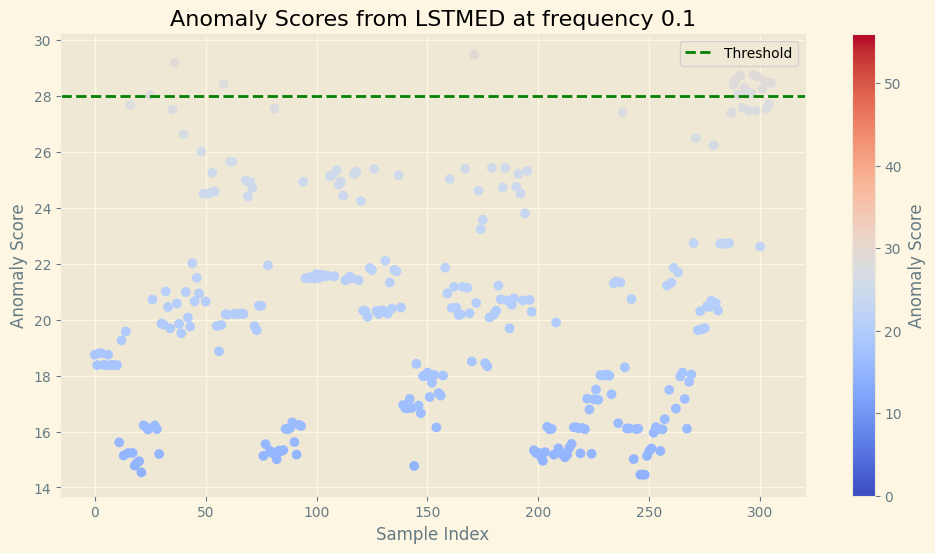

Number of anomalies detected: 16


(array([18.748579 , 18.3748   , 18.800985 , 18.803696 , 18.391127 ,
        18.3748   , 18.748579 , 18.3748   , 18.3748   , 18.3748   ,
        18.3748   , 15.612818 , 19.261114 , 15.142943 , 19.581776 ,
        15.231048 , 27.678593 , 15.234321 , 14.778795 , 14.883269 ,
        14.939625 , 14.539765 , 16.222263 , 16.165453 , 16.071207 ,
        28.032879 , 20.720194 , 16.22124  , 16.086285 , 15.1959505,
        19.864809 , 19.825863 , 21.014154 , 20.456102 , 19.692646 ,
        27.51875  , 29.195095 , 20.579094 , 19.853586 , 19.515234 ,
        26.630451 , 20.991693 , 20.080631 , 19.756268 , 22.024445 ,
        20.656616 , 21.498468 , 20.940237 , 26.012669 , 24.507004 ,
        20.653591 , 24.509476 , 24.53566  , 25.260956 , 24.592796 ,
        19.779392 , 18.870222 , 19.810509 , 28.43803  , 20.195595 ,
        20.183289 , 25.654575 , 25.646812 , 20.205975 , 20.219898 ,
        20.20279  , 20.223251 , 20.206211 , 24.978024 , 24.405964 ,
        24.920237 , 24.72196  , 19.768082 , 19.6

In [23]:
# Plot anomalies
#threshold = np.mean(sliding_window_scores) + 2 * np.std(sliding_window_scores)
#plot_anomalies(sliding_window_scores, y_test, freq, threshold)
plot_anomalies(xgb_model, X_test, y_test, freq)

In [23]:
# Compute metrics
#metrics = compute_metrics(y_test, sliding_window_scores, threshold)
#print("Anomaly Detection Metrics:")
#for metric, value in metrics.items():
#    print(f"{metric}: {value:.4f}")
anomaly_scores, y_test_binary = compute_metrics(xgb_model, X_test, y_test)

Anomaly scores statistics:
Mean: 12.986799240112305
Std: 7.714588642120361
Min: -0.45087066292762756
Max: 29.815284729003906
ROC AUC Score: 0.9906
Detected anomaly class: 29
Threshold: 28.4160
F1 Score: 0.6667
Accuracy: 0.9869
Precision: 0.6667
Recall: 0.6667
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       300
           1       0.67      0.67      0.67         6

    accuracy                           0.99       306
   macro avg       0.83      0.83      0.83       306
weighted avg       0.99      0.99      0.99       306



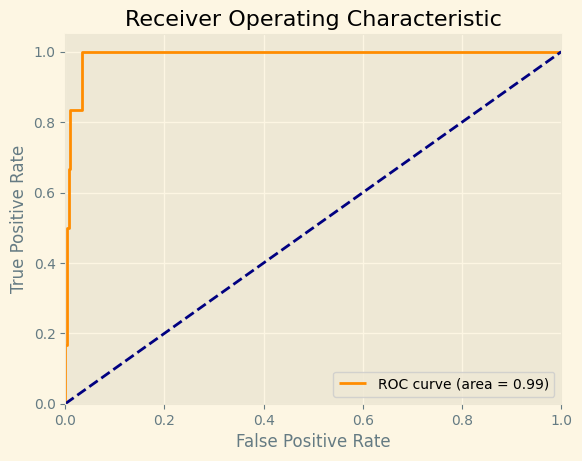

In [24]:
plot_roc_curve(y_test_binary, anomaly_scores)

## Map anomalies to original time series

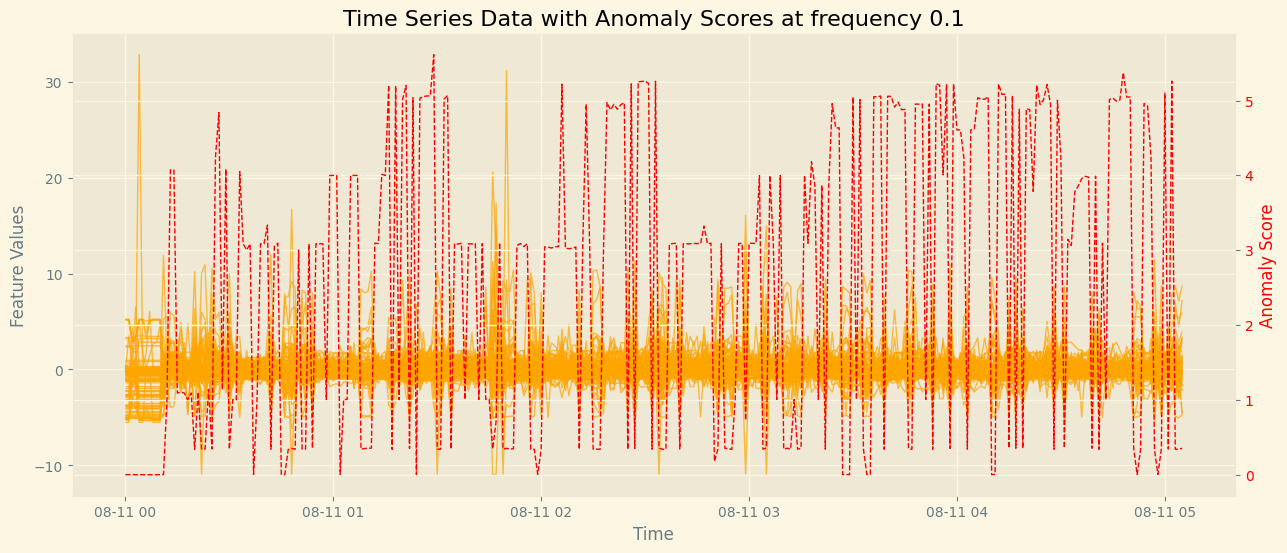

Top 0 Anomalies:
Empty DataFrame
Columns: [timestamp, anomaly_score, machine_nameKuka Robot_apparent_power-_Average power, machine_nameKuka Robot_apparent_power-_Variance, machine_nameKuka Robot_current-_Min, machine_nameKuka Robot_phase_angle-_Average power, machine_nameKuka Robot_phase_angle-_Variance, machine_nameKuka Robot_power-_ECDF Percentile_0, machine_nameKuka Robot_power-_Min, machine_nameKuka Robot_power_factor-_Histogram_9, machine_nameKuka Robot_reactive_power-_Absolute energy, machine_nameKuka Robot_reactive_power-_ECDF Percentile_0, machine_nameKuka Robot_reactive_power-_ECDF Percentile_1, machine_nameKuka Robot_reactive_power-_Mean absolute deviation, sensor_id1_AccX-_Histogram_5, sensor_id1_AccX-_Histogram_7, sensor_id1_AccY-_Interquartile range, sensor_id1_AccY-_Kurtosis, sensor_id1_AccZ-_Average power, sensor_id1_AngX-_Kurtosis, sensor_id1_AngX-_Max, sensor_id1_AngX-_Median absolute deviation, sensor_id1_AngY-_ECDF Percentile_1, sensor_id1_AngY-_Median, sensor_id1_An

In [13]:
plot_anomalies_over_time(X_test, anomaly_scores, sum(anomaly_scores > np.mean(anomaly_scores) + 2 * np.std(anomaly_scores)), freq)

## Feature Importance Analysis

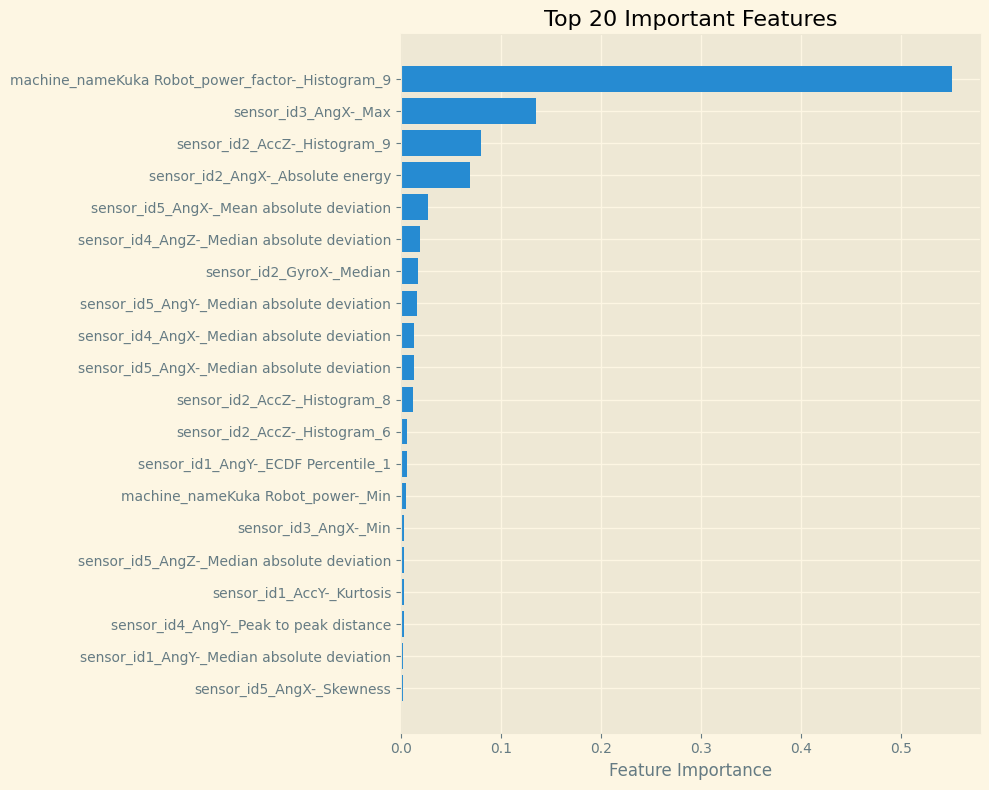

In [14]:
# Train a final model on the entire dataset to get feature importances
final_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
final_model.fit(X_train, y_train)

feature_importance = final_model.feature_importances_
feature_names = X_train.columns

# Sort features by importance
sorted_idx = np.argsort(feature_importance)
sorted_features = feature_names[sorted_idx]
sorted_importance = feature_importance[sorted_idx]

# Plot top 20 features
plt.figure(figsize=(10, 8))
plt.barh(range(20), sorted_importance[-20:])
plt.yticks(range(20), sorted_features[-20:])
plt.xlabel('Feature Importance')
plt.title('Top 20 Important Features')
plt.tight_layout()
plt.show()